# Logistic regression for a binary classification with a regularization
## 융합공학부 디지털이미징전공 4학년 신준섭 20175437

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import time

## Training Data
* loading datas from ```data-nonlinear.txt```
* each row $ \{ x^{(i)}, y^{(i)}, l^{(i)} \}$ od the data consists of 2D point $(x, y)$ with its label $l$
* since it is binary classification problem, and with real point $(x, y)$
$$(x, y) \in \mathbb{R},    l \in {0, 1} $$

In [2]:
data    = np.genfromtxt("data-nonlinear.txt", delimiter=',')

pointX  = data[:, 0]
pointY  = data[:, 1]
label   = data[:, 2]

pointX0 = pointX[label == 0]
pointY0 = pointY[label == 0]

pointX1 = pointX[label == 1]
pointY1 = pointY[label == 1]

## Matrix representations

$$ x_i = [1, x^{(i)}, y^{(i)}]^T$$
where this can be formed in Matrix representaion
\begin{gather}
    D = 
    \begin{bmatrix}
        x_1^T \\ ... \\ x_N^T
    \end{bmatrix}
    =
    \begin{bmatrix}
        1 & x_{1} & y_{1} \\ & ... & \\ 1 & x_{N} & y_{N}
    \end{bmatrix}
\end{gather}
for the label $l_{i} \in \{0, 1\}$
\begin{gather}
    L =
    \begin{bmatrix}
        l_1 \\ l_2 \\ ... \\ l_N
    \end{bmatrix}
\end{gather}


In [3]:
N = len(label)
Ones = np.ones((N, 1), dtype=float)
Xs = np.matrix(pointX.reshape(N, 1))
Ys = np.matrix(pointY.reshape(N, 1))

D = np.concatenate((Ones, Xs, Ys), axis=1)
L = np.matrix(label).reshape(N, 1)

## Logistic regression with a high dimensional feature function
* the sigmoid function for classification
$$\sigma(z) = \frac{1}{1+\exp\{-z\}}$$
* derivative of the sigmoid
$$\sigma^{'}(z) = \sigma(z)(1-\sigma(z))$$

In [4]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-1.0 * z))

def deriv_sigmoid(z):
    _ones = np.ones(z.shape)
    return np.multiply(sigmoid(z), _ones - sigmoid)

## Defining the matrix form linear combination

* if we let $F$ to be
$$F = [1, x, x^2, ... , x^9, y, xy, x^y, ..., x^9y, y^2, ..., ..., x^9y^9]$$

* and for theta
$$ \Theta = [\theta_{0,0}, \theta_{1,0}, \theta_{2,0}, ..., \theta_{9,0}, \theta_{0,1}, ..., ..., \theta_{9,9}] $$

* we can define the linear combination by matrix multiplication as
$$G = F\Theta$$

* since we have $N$ datasets, to form the total $\mathbf{F}$ we need to concatenate all $F_k$
$$\mathbf{F} = [F_0, F_1, ... F_N]^T$$

* then overall linear combination of all data points is
$$\mathbf{G} = \mathbf{F}\Theta$$

In [5]:
F = []

for k in range(N):
    Fk = []
    xk = D[k, 1]
    yk = D[k, 2]
    for j in range(10):
        for i in range(10):
            Fk.append(np.power(xk, i) * np.power(yk, j))
    F.append(Fk)
F = np.matrix(F)

## Defining the objective function
* by using the matrix form, the objective function can be formed as
$$\hat{J}(\theta) = \frac{1}{N} \sum_{i=1}^{N} \left[  -L_k \log(\sigma(G_k)) - (1-L_k) \log(1-\sigma(G_k)) \right] $$

* with regularization term
$$L(\theta) =  \sum_{i=0}^{9} \sum_{j=0}^{9} \theta_{i,j}^2 $$

* then the total objective function becomds
$$J(\theta) = \hat{J}(\theta) + \frac{\lambda}{2} L(\theta)$$

In [29]:
def regularization(Theta):
    return np.sum(np.square(Theta))

def objectiveFunction(Theta, reg_const):
    Ones = np.ones(L.shape)
    G = np.matmul(F,Theta)
    left_term = np.multiply(-1.0 * L, np.log(sigmoid(G)))
    right_term = np.multiply(Ones - L, np.log(Ones - sigmoid(G)))
    reg_term = (reg_const / 2.0) * regularization(Theta)

    return (1.0 / N) * np.sum(left_term - right_term) + reg_term


In [49]:
def gradientDescent(Theta, reg_const, lr):
    G = np.matmul(F, Theta)
    gradient = np.zeros(Theta.shape)

    error = sigmoid(G) - L
    for t in range(100):
        gradient[t] = (1.0 / N) * np.sum(np.multiply(error, F[:,t])) + reg_const * Theta[t]

    return Theta - lr * gradient

## Training

In [81]:
theta = [np.zeros((100, 1)), np.zeros((100, 1)), np.zeros((100, 1))]
reg_const = [0.00001, 0.01, 1]
lr = 5.0
decay_rate = 1.0001

losses = [[], [], []]
accuracies = [[], [], []]
iterations = 0

for i in range(3):
    lr = 5.0
    iterations = 0
    while iterations < 10000:
        losses[i].append(objectiveFunction(theta[i], reg_const[i]))
        correct = np.sum(np.where(np.abs(sigmoid(np.matmul(F, theta[i])) - L) < 0.5, 1.0, 0.0))
        accuracies[i].append(correct / N)
        theta[i] = gradientDescent(theta[i], reg_const[i], lr)
        iterations = iterations + 1
        lr = lr * decay_rate


loss = 0.28520515313403355
accy = 0.8898305084745762
time = 20.293753147125244
time per iteration = 0.002029375314712524
last lr = 13.590729634124424


# Plotting the results

## 1. Plot the training data

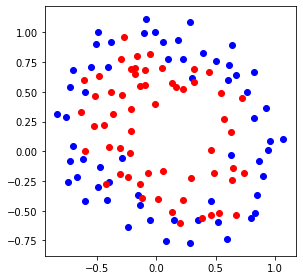

In [75]:
plt.figure()
plt.scatter(pointX0, pointY0, c='b')
plt.scatter(pointX1, pointY1, c='r')
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 2. Plot the training error with varying regularization parameters
## 3. Display the values of the chosen regularization parameters

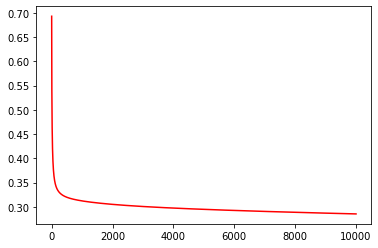

In [82]:
iter_x = list(range(iterations))

plt.plot(iter_x, losses, color='red')
#plt.plot(iter_x, losses[1], color='green')
#plt.plot(iter_x, losses[2], color='blue')

#plt.text(275, 0.35, str(reg_const[0]), color='red')
#plt.text(275, 0.41, str(reg_const[1]), color='green')
#plt.text(275, 0.49, str(reg_const[2]), color='blue')

plt.show()

## 4. Plot the training accuracy with varying regularization parameters
## 5. Display the final training accuracy with varying regularization parameters

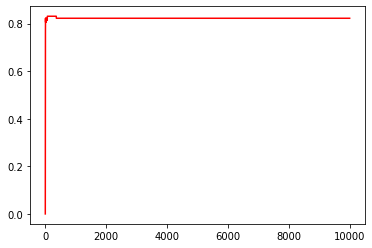

In [64]:
plt.plot(iter_x, accuracies, color='red')
# plt.plot(iter_x, accuracies[1], color='green')
# plt.plot(iter_x, accuracies[2], color='blue')
# 
# dis_acc0 = np.round(accuracies[0][-1], 3)
# dis_acc1 = np.round(accuracies[1][-1], 3)
# dis_acc2 = np.round(accuracies[2][-1], 3)
# 
# plt.text(275, 0.85, str(dis_acc0), color='red')
# plt.text(275, 0.835, str(dis_acc1), color='green')
# plt.text(275, 0.815,  str(dis_acc2), color='blue')

plt.show()

## 6. Plot the optimal classifier with varying regularization parameters superimposed on the training data

[[-1.   -0.99 -0.98 ...  1.27  1.28  1.29]
 [-1.   -0.99 -0.98 ...  1.27  1.28  1.29]
 [-1.   -0.99 -0.98 ...  1.27  1.28  1.29]
 ...
 [-1.   -0.99 -0.98 ...  1.27  1.28  1.29]
 [-1.   -0.99 -0.98 ...  1.27  1.28  1.29]
 [-1.   -0.99 -0.98 ...  1.27  1.28  1.29]]


NameError: name '_fke' is not defined